
<div style="border:1px solid #e5e7eb; border-radius:14px; padding:18px; background:#fafafa; font-family:Arial;">
  <h1 style="margin:0; color:#111827; font-size:26px;">Spotting Outliers in Network Traffic</h1>
    <br>
    <h1 style="color:teal; font-family:Arial; font-size:25px; margin:0;">Han Thao Nguyen - July/Aug 2025</h1>
    <br>
  <p style="margin:6px 0 0; color:#374151; font-size:14px;">
    <b>Objective.</b> Use a 5,000–8,000 row subset of CIC‑IDS 2017 to surface unusual flows with two unsupervised techniques: 
    <b>Isolation Forest</b> and <b>Local Outlier Factor (LOF)</b>. Keep the prep practical, the visuals simple, and the explanations SOC‑friendly.
  </p>
</div>



<h2 style="color:#065f46; font-size:20px; margin:16px 0 6px; font-family:Arial;">Part 1  ·  Prep the Data</h2>
<div style="font-family:Arial; color:#374151; font-size:14px; line-height:1.6;">
  <ul style="margin:0 0 8px 18px;">
    <li>Clean column names and sample 5k–8k rows across multiple days to avoid bias.</li>
    <li>Drop identifiers and empty or constant columns.</li>
    <li>Replace non‑finite values with NaN, impute by median, then apply robust scaling.</li>
  </ul>
  <p style="margin:0;"><i>Note:</i> Any available label is used only for context, not for training.</p>
</div>


In [1]:

# Part 1 · Data loading and preparation
import os, numpy as np, pandas as pd, warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from IPython.display import display

warnings.filterwarnings("ignore", message="invalid value encountered in divide", category=RuntimeWarning)

CANDIDATES_BUDGET = {
    "Monday-WorkingHours.pcap_ISCX.csv":                       2000,
    "Tuesday-WorkingHours.pcap_ISCX.csv":                      1500,
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv":  1500,
    "Friday-WorkingHours-Morning.pcap_ISCX.csv":               1000,
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv":     600,
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv":         600,
}
TARGET_MIN, TARGET_MAX = 5000, 8000
RANDOM_SEED = 42
rng = np.random.RandomState(RANDOM_SEED)

def clean_col(c):
    return (str(c).strip()
            .replace(" ", "_").replace("/", "_").replace("\\", "_")
            .replace("(", "").replace(")", "").replace("-", "_").lower())

def find_label_column(cols):
    for c in cols:
        if c.lower() in {"label", "class", "attack_cat"}:
            return c
    for c in cols:
        cl = c.lower()
        if "label" in cl or "attack" in cl or "class" in cl:
            return c
    return None

def resolve_path(name):
    if os.path.exists(name): 
        return name
    if not name.lower().endswith(".csv"):
        for cand in [name + ".pcap_ISCX.csv", name + "_ISCX.csv"]:
            if os.path.exists(cand): return cand
    stem = name.lower().replace(".csv","").replace(".pcap","")
    for root, _, files in os.walk(".", topdown=True):
        for f in files:
            fl = f.lower()
            if fl.endswith(".csv") and stem in fl:
                return os.path.join(root, f)
    return None

def read_csv_any(path):
    try:    return pd.read_csv(path)
    except UnicodeDecodeError:
            return pd.read_csv(path, encoding="latin1")

frames = []
for fname, budget in CANDIDATES_BUDGET.items():
    path = resolve_path(fname)
    if not path or budget <= 0:
        continue
    df = read_csv_any(path); df.columns = [clean_col(c) for c in df.columns]
    lab = find_label_column(df.columns)
    take = min(budget, len(df))
    part = df.sample(n=take, random_state=RANDOM_SEED)
    part["__source_file__"] = os.path.basename(path)
    if lab is not None:
        part["__label__"] = (part[lab].astype(str).str.upper() != "BENIGN").astype(int)
    frames.append(part)

raw = pd.concat(frames, ignore_index=True).drop_duplicates()

if len(raw) > TARGET_MAX:
    raw = raw.sample(n=TARGET_MAX, random_state=RANDOM_SEED).reset_index(drop=True)

drop_like = {"source_ip","destination_ip","src_ip","dst_ip","timestamp","flow_id","protocol","protocol_type","service","__source_file__"}
X0 = raw.drop(columns=[c for c in raw.columns if c in drop_like], errors="ignore")

numeric_cols = [c for c in X0.columns if np.issubdtype(X0[c].dtype, np.number)]
X1 = X0[numeric_cols].copy()

X1 = X1.replace([np.inf, -np.inf], np.nan)
X1 = X1.where(np.isfinite(X1), np.nan)
all_nan_cols = list(X1.columns[X1.isna().all()])
if all_nan_cols:
    X1 = X1.drop(columns=all_nan_cols)

imputer = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imputer.fit_transform(X1), columns=X1.columns)

stds = X_imp.std(axis=0, ddof=0)
keep = list(stds[stds > 0].index)
X_imp = X_imp[keep]

scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X_imp.columns)

pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pd.DataFrame(pca.fit_transform(X_scaled), columns=["pc1","pc2"])
y_label = raw["__label__"] if "__label__" in raw.columns else None



<h2 style="color:#065f46; font-size:20px; margin:16px 0 6px; font-family:Arial;">Part 2  ·  Two Anomaly Techniques</h2>
<p style="font-family:Arial; color:#374151; font-size:14px; line-height:1.6;">
<b>Isolation Forest</b> isolates rare points using random splits. <b>LOF</b> flags points with much lower local density than their neighbors.
We show summary counts, top anomalies, and a 2‑D PCA view for intuition.
</p>



<h3 style="color:#1f2937; font-size:18px; margin:12px 0 4px; font-family:Arial;">Technique A: Isolation Forest</h3>
<p style="font-family:Arial; color:#374151; font-size:14px; line-height:1.6;">
Set a small contamination rate as a starting point and review the top scored flows. Use the PCA plot to sanity check separation.
</p>


In [2]:

# Part 2A · Isolation Forest
from sklearn.ensemble import IsolationForest
import numpy as np, pandas as pd

IF_CONTAM = 0.02
iso = IsolationForest(n_estimators=300, contamination=IF_CONTAM, random_state=42, n_jobs=-1)
iso.fit(X_scaled)
if_scores = -iso.score_samples(X_scaled) # higher means more anomalous
if_flags = (iso.predict(X_scaled) == -1).astype(int) 

top_if = pd.DataFrame({"idx": np.arange(len(X_scaled)), "if_anom_score": if_scores, "if_flag": if_flags}).sort_values("if_anom_score", ascending=False)
display(top_if.head(10))

,idx,if_anom_score,if_flag
6725,6725,0.714935,1
6680,6680,0.712628,1
4899,4899,0.707626,1
3553,3553,0.707299,1
3467,3467,0.706001,1
2947,2947,0.699556,1
1923,1923,0.695878,1
6942,6942,0.692407,1
7116,7116,0.691768,1
2489,2489,0.690702,1



<h3 style="color:#1f2937; font-size:18px; margin:12px 0 4px; font-family:Arial;">Technique B: Local Outlier Factor (LOF)</h3>
<p style="font-family:Arial; color:#374151; font-size:14px; line-height:1.6;">
Use neighbors to estimate local density and flag points that live in sparse neighborhoods. Robust scaling helps distance‑based methods.
</p>


In [3]:

# Part 2B · Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor
import numpy as np, pandas as pd

LOF_K = 20
lof = LocalOutlierFactor(n_neighbors=LOF_K, contamination=0.02, novelty=False)
lof_labels = lof.fit_predict(X_scaled)
lof_flags = (lof_labels == -1).astype(int)
lof_scores = -lof.negative_outlier_factor_

top_lof = pd.DataFrame({"idx": np.arange(len(X_scaled)), "lof_anom_score": lof_scores, "lof_flags" : lof_flags }).sort_values("lof_anom_score", ascending=False)
display(top_lof.head(10))



,idx,lof_anom_score,lof_flags
3634,3634,48.232755,1
3959,3959,45.682692,1
1756,1756,29.947620,1
492,492,27.248902,1
282,282,21.692631,1
673,673,21.685418,1
2035,2035,21.658153,1
4224,4224,21.391105,1
1288,1288,19.779457,1
1212,1212,19.759024,1


Isolation Forest outliers: 144
LOF outliers: 144


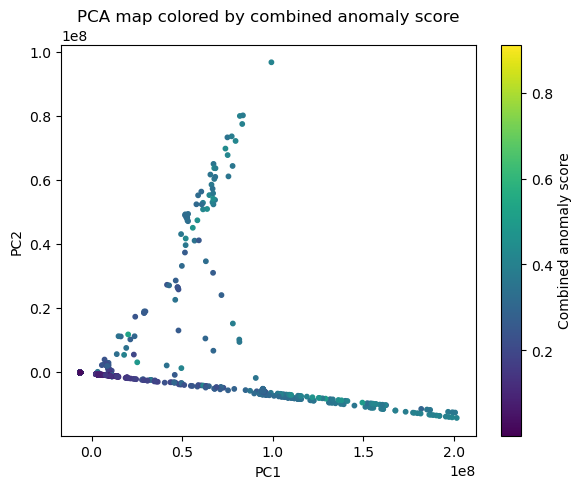

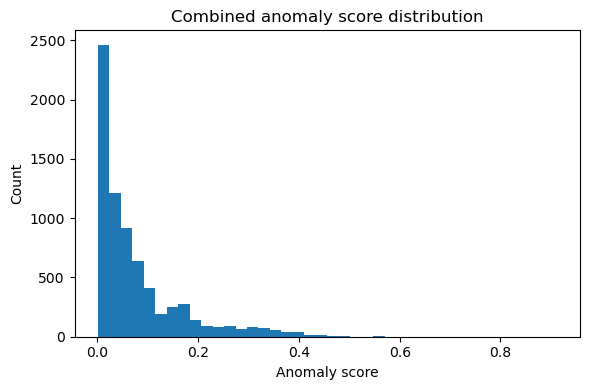

,idx,combo,if_score,lof_score
3634,3634,0.912382,0.645269,48.232755
3959,3959,0.780837,0.562111,45.682692
3553,3553,0.573310,0.707299,8.778833
3467,3467,0.567193,0.706001,8.354591
4887,4887,0.561117,0.623282,17.621007
1923,1923,0.528726,0.695878,5.920128
6725,6725,0.501734,0.714935,1.099753
6680,6680,0.498031,0.712628,1.023840
4899,4899,0.495594,0.707626,1.388468
4608,4608,0.491072,0.605150,13.152304


In [4]:
# 2 simple chart (PCA map colored by combo score, histogram of combined scores)

import matplotlib.pyplot as plt

# Normalize scores to 0..1 and average for one "combo score"
s_if  = (if_scores - if_scores.min()) / (if_scores.ptp() + 1e-9)
s_lof = (lof_scores - lof_scores.min()) / (lof_scores.ptp() + 1e-9)
combo = 0.5*s_if + 0.5*s_lof

print("Isolation Forest outliers:", int(if_flags.sum()))
print("LOF outliers:", int(lof_flags.sum()))

# Chart 1: PCA map colored by combo score
plt.figure(figsize=(6,5))
sc = plt.scatter(X_pca["pc1"], X_pca["pc2"], c=combo, s=10)
plt.colorbar(sc, label="Combined anomaly score")
plt.title("PCA map colored by combined anomaly score")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

# Chart 2: Histogram of combined scores
plt.figure(figsize=(6,4))
plt.hist(combo, bins=40)
plt.title("Combined anomaly score distribution")
plt.xlabel("Anomaly score"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Top ranked anomalies for quick review
ranked = pd.DataFrame({
    "idx": np.arange(len(combo)),
    "combo": combo,
    "if_score": if_scores,
    "lof_score": lof_scores
}).sort_values("combo", ascending=False)
display(ranked.head(10))


<h2 style="color:#065f46; font-size:20px; margin:16px 0 6px; font-family:Arial;">Part 3  ·  Explain What We Found</h2>
<p style="font-family:Arial; color:#374151; font-size:14px; line-height:1.6;">
We pull three examples at the top of the combined ranking and explain why each looks suspicious.
The reasons rely on simple signals that analysts understand quickly: destination port context, very high byte or packet rates, extreme flow duration, timing regularity or burstiness, window sizes, and direction asymmetry.
</p>


In [5]:

# Part 3 · Three example anomalies and reasons
import numpy as np, pandas as pd
from IPython.display import display, HTML

# Part 3 · Three anomaly examples with simple, concrete reasons
def pct(col, v):
    if col not in X_imp.columns or pd.isna(v): 
        return np.nan
    return float((X_imp[col] <= v).mean())

def explain_row(r):
    reasons = []

    # Destination port context
    if "destination_port" in raw.columns and pd.notna(r.get("destination_port", np.nan)):
        d = int(r["destination_port"])
        if d in {22,23,3389,445}:
            reasons.append(f"traffic to sensitive service port {d}")
        elif d < 1024:
            reasons.append(f"traffic to a privileged port {d}")

    # Byte and packet rates
    for col, label in [("flow_bytes_s","byte rate"), ("flow_packets_s","packet rate"), ("fwd_packets_s","forward packet rate")]:
        if col in X_imp.columns and pd.notna(r.get(col, np.nan)):
            p = pct(col, r[col])
            if p >= 0.99:
                reasons.append(f"extremely high {label} at or above the 99th percentile")
            elif p >= 0.95:
                reasons.append(f"very high {label} at or above the 95th percentile")

    # Flow duration extremes
    if "flow_duration" in X_imp.columns and pd.notna(r.get("flow_duration", np.nan)):
        p = pct("flow_duration", r["flow_duration"])
        if p <= 0.01:
            reasons.append("very short flow duration at or below the 1st percentile")
        elif p >= 0.99:
            reasons.append("very long flow duration at or above the 99th percentile")

    # Timing irregularity (IAT)
    for col, label in [("fwd_iat_std","forward IAT variability"), ("bwd_iat_std","backward IAT variability")]:
        if col in X_imp.columns and pd.notna(r.get(col, np.nan)):
            p = pct(col, r[col])
            if p <= 0.01:
                reasons.append(f"highly regular {label} at or below the 1st percentile")
            elif p >= 0.99:
                reasons.append(f"highly bursty {label} at or above the 99th percentile")

    # Direction asymmetry
    for a, b, name in [("subflow_fwd_bytes","subflow_bwd_bytes","byte direction asymmetry"),
                       ("total_fwd_packets","total_bwd_packets","packet direction asymmetry")]:
        if a in X_imp.columns and b in X_imp.columns and pd.notna(r.get(a, np.nan)) and pd.notna(r.get(b, np.nan)):
            f, bwd = float(r[a]), float(r[b])
            if (f + bwd) > 0:
                ratio = max(f, bwd) / (min(f, bwd) + 1e-9)
                if ratio >= 50:
                    reasons.append("extreme " + name + " with a ratio of at least 50 to 1")

    # TCP windows
    for col, label in [("init_win_bytes_forward","client window size"), ("init_win_bytes_backward","server window size")]:
        if col in X_imp.columns and pd.notna(r.get(col, np.nan)):
            p = pct(col, r[col])
            if p <= 0.01:
                reasons.append(f"unusually small {label} at or below the 1st percentile")
            elif p >= 0.99:
                reasons.append(f"unusually large {label} at or above the 99th percentile")

    if not reasons:
        reasons.append("high anomaly scores from both methods with no benign explanation in visible fields")
    return reasons

# Take top three by combined score
top3_idx = ranked.head(3)["idx"].tolist()

cards = ["<div style='display:grid; grid-template-columns:repeat(auto-fit,minmax(280px,1fr)); gap:12px; font-family:Arial;'>"]
for i in top3_idx:
    r = raw.iloc[i]
    rs = explain_row(r)
    bullets = "".join([f"<li>{x}</li>" for x in rs])
    header = f"Anomaly example · index {int(i)}"
    meta = f"dest_port: {r.get('destination_port','NA')} · bytes_s: {r.get('flow_bytes_s','NA')} · pkts_s: {r.get('flow_packets_s','NA')}"
    cards.append(
        "<div style='border:1px solid #e5e7eb; border-radius:12px; padding:12px;'>"
        f"<div style='font-weight:700; color:#111827; margin-bottom:6px;'>{header}</div>"
        f"<div style='font-size:13px; color:#374151; margin-bottom:4px;'>{meta}</div>"
        f"<ul style='margin:6px 0 0 16px; padding:0; font-size:13px; color:#111827;'>{bullets}</ul>"
        "</div>"
    )
cards.append("</div>")
display(HTML("".join(cards)))

# Save simple artifacts
import pandas as pd
pd.DataFrame({"top3_idx": top3_idx}).to_csv("assignment5_top3_indices.csv", index=False)